# DETR Model Training (Caltech)
**Purpose: Train DETR model on Caltech dataset**</br>
**Final Project**</br>
**Group 1**</br>
**DS6050 Deep Learning**</br>
**Fall 2023**</br>

**Resources:**
- https://github.com/aivclab/detr/blob/master/finetune_detr.ipynb
- https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb#scrollTo=DAhihLFcb34k
- https://colab.research.google.com/github/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
- https://colab.research.google.com/github/woctezuma/finetune-detr/blob/master/finetune_detectron2.ipynb

In [25]:
!/home/ybt7qf/myenv/bin/python3 -m pip install transformers pytorch-lightning tensorboard wandb coco-eval scipy scikit-learn -U -q

In [2]:
import os
import argparse
import torch
import torchvision
import numpy as np
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from transformers import DetrConfig, DetrForObjectDetection, DetrImageProcessor
from coco_eval import CocoEvaluator

In [3]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, annotation_folder, processor, train=True):
        ann_file = os.path.join(annotation_folder, "instances_train2017.json" if train else "instances_val2017.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        # replace COCO classification head with custom head
        # we specify the "no_timm" variant here to not rely on the timm library
        # for the convolutional backbone
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                         revision="no_timm", 
                                                         num_labels=len(id2label),
                                                         ignore_mismatched_sizes=True)
        # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader
    
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch    

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [4]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder='/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/train2017', 
                              annotation_folder='/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/annotations',
                              processor=processor)
val_dataset = CocoDetection(img_folder='/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/val2017', 
                            annotation_folder='/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/annotations',
                            processor=processor, train=False)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Number of training examples: 10000
Number of validation examples: 2498


Image n°6251


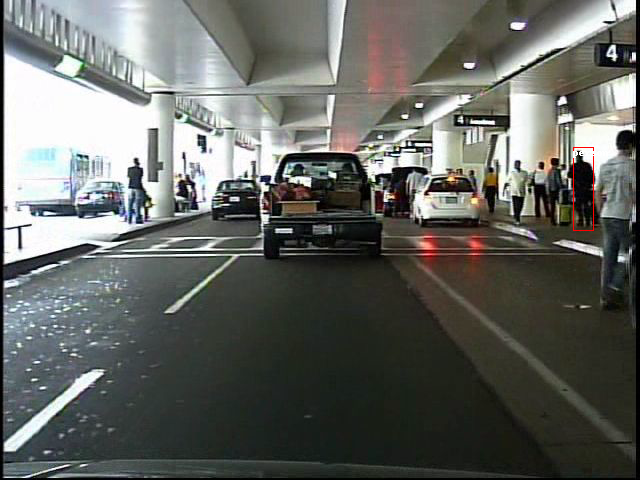

In [5]:
# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image_dir = "/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/train2017"
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(image_dir, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
    draw.text((x, y), id2label[class_idx], fill='white')

image

In [14]:
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=32)
batch = next(iter(train_dataloader))

In [15]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

In [16]:
# wandb_logger = WandbLogger(project="DS6050_Pedestrian_ECP_DETR", log_model="all")
trainer = Trainer(max_steps=1, gradient_clip_val=0.1),# logger=wandb_logger)
trainer.fit(model)

In [43]:
# !/home/ybt7qf/myenv/bin/python3 train-detr.py  \
#     --img_folder_train /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/train2017 \
#     --img_folder_val /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/val2017 \
#     --annotation_folder /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/annotations \
#     --num_workers 7 \
#     --batch_size 32

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Number of training examples: 10000
Number of validation examples: 2498
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ybt7qf/myenv/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191

In [45]:
# model = DetrForObjectDetection.from_pretrained("dscerbo/detr-finetuned-ds6050-project", id2label={0:"person"})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# processor = DetrImageProcessor.from_pretrained("dscerbo/detr-finetuned-ds6050-project")

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): ResNetBackbone(
            (embedder): ResNetEmbeddings(
              (embedder): ResNetConvLayer(
                (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (normalization): DetrFrozenBatchNorm2d()
                (activation): ReLU()
              )
              (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            )
            (encoder): ResNetEncoder(
              (stages): ModuleList(
                (0): ResNetStage(
                  (layers): Sequential(
                    (0): ResNetBottleNeckLayer(
                      (shortcut): ResNetShortCut(
                        (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                        (normalization): DetrFrozenBatchNorm2d

In [46]:
# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    # provide to metric
    # metric expects a list of dictionaries, each item 
    # containing image_id, category_id, bbox and score keys 
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/79 [00:00<?, ?it/s]

KeyError: 'annotations'

In [ ]:
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[1]

In [ ]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

In [ ]:
with torch.no_grad():
    # forward pass to get class logits and bounding boxes
    outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

In [ ]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
# load image based on ID
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/val2017', image['file_name']))

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.9)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [36]:
# !/home/ybt7qf/myenv/bin/python3 detr/main.py \
#   --dataset_file coco \
#   --coco_path /scratch/ybt7qf/ds6050-group1-project/datasets/caltechpedestriandataset/ \
#   --output_dir detr_outputs/ \
#   --resume detr-r50_no-class-head.pth \
#   --lr 1e-5 \
#   --lr_backbone 1e-6 \
#   --epochs 1

| distributed init (rank 0): env://
Traceback (most recent call last):
  File "/sfs/qumulo/qhome/ybt7qf/ds6050-group1-project/detr/main.py", line 248, in <module>
    main(args)
  File "/sfs/qumulo/qhome/ybt7qf/ds6050-group1-project/detr/main.py", line 106, in main
    utils.init_distributed_mode(args)
  File "/sfs/qumulo/qhome/ybt7qf/ds6050-group1-project/detr/util/misc.py", line 426, in init_distributed_mode
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
  File "/home/ybt7qf/myenv/lib/python3.11/site-packages/torch/distributed/c10d_logger.py", line 74, in wrapper
    func_return = func(*args, **kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^
  File "/home/ybt7qf/myenv/lib/python3.11/site-packages/torch/distributed/distributed_c10d.py", line 1141, in init_process_group
    store, rank, world_size = next(rendezvous_iterator)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ybt7qf/myenv/lib/python3.11/site-packages/tor